# Data Sctructure and Importing
Our primary goal here is to import, interpolate, and extend our bike riding GPS data. It'll be somewhat complicated as it is not small task on code, but using vectorization on all processes will keep execution really fast. We have for this task about 1.7M datapoints. Each datapoint corresponds to a fancy **one point in space time**, i.e. one point made of 4 dimensions of timestamp, latitude, longitude and elevation. We hope that connection each one sequentially on time will render a path that a biker rode. To guarantee bookeeping and post processing capabilities, we will record the point id, ride id and rider id.





In [3]:
# import needed packages
import gpxpy
import datetime 
import time
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import numpy as np
import re
import sys
import pandas as pd
import pickle as pk
from tqdm import tqdm_notebook as tqdm
from geopy.distance import great_circle
# from scipy.signal import gaussian
# from scipy.ndimage import filters
from scipy.ndimage.filters import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nvector as nv
from pandas.plotting import andrews_curves


In [324]:
# load the gpx data
gpx_filename_pattern = re.compile("(gpx)$")

import plotly
# plotly.offline.init_notebook_mode()

def build_meta(gpx): 
    meta = {
        "tracks": 0,
        "segments": 0,
        "points": 0
    }
    for track in gpx.tracks:
        meta["tracks"] += 1
        for segment in track.segments:
            meta["segments"] += 1
            for point in segment.points:
                meta["points"] += 1
    return meta

def import_gpx_file(path, filename):
    build_meta
    file = open(path+'/'+filename, 'r')
    gpx = gpxpy.parse(file)
    meta = build_meta(gpx)
    data = np.zeros((meta['points'], 5))
    n = 0
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                t = time.mktime(point.time.timetuple())
                data[n, ] = [point.latitude, point.longitude, point.elevation, t, n]
                n += 1
    return pd.DataFrame({
        'latitude': data[:,0],
        'longitude': data[:,1],
        'elevation': data[:,2],
        'timestamp': data[:,3],
        'point': data[:,4],
        'ride': 0,
        'rider': ""
    })

def import_gpx_dir(path):
    filenames = [f for f in os.listdir(path) if gpx_filename_pattern.search(f)]    
    data = pd.DataFrame()
    n = 0
    for filename in tqdm(filenames, total=len(filenames)):
        dt = import_gpx_file(path, filename)
        dt['ride'] = n
        n += 1
        data = data.append(dt, ignore_index=True)
    return data

def interpret_gpx(path, name):
    data = import_gpx_dir(path)
    data["rider"] = name
    data.elevation = data.elevation.astype(int)
    data.timestamp = data.timestamp.astype(int)
    data.point = data.point.astype(int)
    #save to cache
    cache = open(str(name)+'.pkl', 'wb')
    pk.dump(data, cache)
    cache.close()
    return data

def load_gpx(path):
    cache = open(path, 'rb')
    data = pk.load(cache)
    cache.close()
    return data

def save_data(data, name):
    cache = open(name+".pkl", 'wb')
    pk.dump(data, cache)
    cache.close()
    
def load_data(name):
    cache = open(name+".pkl", 'rb')
    data = pk.load(cache)
    cache.close()
    return data

if(os.path.exists("0.pkl")):
    data1 = load_gpx("0.pkl")
    data2 = load_gpx("1.pkl")
else:
    data1 = interpret_gpx("/Users/esse/activ/rodrigo_sztelzer", 0)
    data2 = interpret_gpx("/Users/esse/activ/marcos_paulo", 1)

data = data1.append(data2, ignore_index=True)
print(data.shape)
print(data.head())

(1739684, 7)
   elevation   latitude  longitude  point  ride  rider   timestamp
0        747 -23.562747 -46.691410      0     0      0  1496509570
1        749 -23.562589 -46.691241      1     0      0  1496509607
2        750 -23.562554 -46.691224      2     0      0  1496509609
3        750 -23.562522 -46.691213      3     0      0  1496509610
4        750 -23.562473 -46.691212      4     0      0  1496509611


# Interpolate the data

The collected sample points are timely defined with a maximum resolution of one second period. There are times that GPS pauses when the rider stops or simply can't tell the localization. We will not care if in this spots there is movement or not, we will just interpolate the points linearly inside this stop by the seconds passed.

There is many good effects to our data. As time gets continuous and defined at one second, many phisical calculations are simplified to already available variables. Speed is simply distance over one second, so, it's equal to pure distance.

The interpolation needs to pay attention to certain problems. There is some small account of long pauses or failures. We will get rid of it and allow a maximum of 4 min of interpolation. In the end, we'll get about 2.3M datapoints.

In [123]:
# create interpolation based on difference of times.
# first, sort rides by timestamp, as it may be in the order of files imported.
data = data.sort_values(['rider', 'timestamp'])
data['duration'] = np.ediff1d(data.timestamp, to_end=0)
#inert points between rides
def last_duration_zero(df):
    df['duration'].iloc[-1] = 0
    return df
data = data.groupby('ride').apply(last_duration_zero)
#inert negative points (generally may occur between riders)
data = data[data.duration > 0]

#ignore pauses longer than 4 minutes.
data = data[data.duration < 4*60]

#repeat the data, set repeats to nan, interpolate nans.
data = data.loc[data.index.repeat(data.duration)]
data['subindex'] = data.groupby(level=0).cumcount()
data[data.subindex > 0] = np.nan
data = data.interpolate()

# clear unused columns
del data['duration']
del data['subindex']

# correct types
data.elevation = data.elevation.astype("int")
data.point = data.groupby([data.ride]).cumcount()
data.ride = data.ride.astype("int")
data.rider = data.rider.astype("int")
data.timestap = data.timestamp.astype("int")

print(data.shape)

(2272711, 7)


In [124]:
save_data(data, "interpolated")

In [5]:
data = load_data("interpolated")

# Understanding our type of dataset and extending it.
Now that we have the crude data, we can infer other ones, like distance, velocity, acceleration, inclination, etc.
It's important to understand where to expand statistically this data. What are our limits? What questions do we want or have to answer. The ideal dataset will be a limited set of:

* Descriptive: the whole population.
* Exploratory: a random sample with many variables.
* Inferential: the right population, randomly sampled.
* Predictive: a sample population divided in training and test.
* Causal: data from a randomized study.
* Mechanistic: data about all components of the system.

It would seem ok to consider our initial data as mechanistic descriptive, but this is not true. What would be the limit of reality? We don't have all datapoints, only a fraction from an irregular readout frequency. We don't have the measures of lots of points, neither properties. They will be infered from the original points, and this is the tip to select another type.

In this study, we will better to consider our dataset as inferential. It's the right population of data because from all geopoints, it's the points that we care about: our path. It is randomly time selected, enough to consider different properties.
After infering more properties from the relationship of a smal account of variables, we will build an exploratory dataset with many more properties.

Finally, we can use this dataset as a Predictive one for use in machine learning algorithms. For a selected rider, we will try to predict it behavior on a certain point of some path.

In [125]:
# create a column with the last points, so to not use loopings anymore
data['llat'] = np.roll(data.latitude, 1, 0)
data['llon'] = np.roll(data.longitude, 1, 0)
data.loc[data.point==0, 'llat'] = data.loc[data.point==0, 'latitude']
data.loc[data.point==0, 'llon'] = data.loc[data.point==0, 'longitude']

In [126]:
# create a column with meters deltas
# very fast vectorized solution
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    meters = 6372800 * c
    return meters

# column with distance (speed)
data['distance'] = haversine(data.llon, data.llat, data.longitude, data.latitude)
#ignore too fast points
data.loc[data.point==0, 'distance'] = 0
data = data[data.distance < 20]
data = data[data.distance > 0]

In [127]:
# create a column with angle in degrees
data['heading'] = np.arctan2(data.longitude-data.llon, data.latitude-data.llat) * 180 / np.pi
data.loc[data.point==0, 'heading'] = 0

In [128]:
# column with deltaspeed (acceleration)
data['deltadistance'] =  np.roll(data.distance, 1, 0) - data.distance
data.loc[data.point==0, 'deltadistance'] = 0

In [129]:
# deltaelevation
data['deltaelevation'] = data.elevation - np.roll(data.elevation, 1, 0)
data['deltaelevation'] = np.clip(data['deltaelevation'], -1, 1)
data.loc[data.point==0, 'deltaelevation'] = 0

In [76]:
# climbrate
data['climb'] = data.deltaelevation / data.distance
data['climb'] = np.clip(data['climb'], -1, 1)



Make a checkpoint of the data.

In [130]:
save_data(data, "extended")

In [5]:
data = load_data("extended")

# Seeing the data

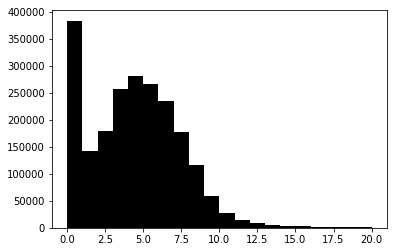

In [6]:
plt.hist(data.distance, bins=20, color='black')
plt.show()

# Simple plot one ride

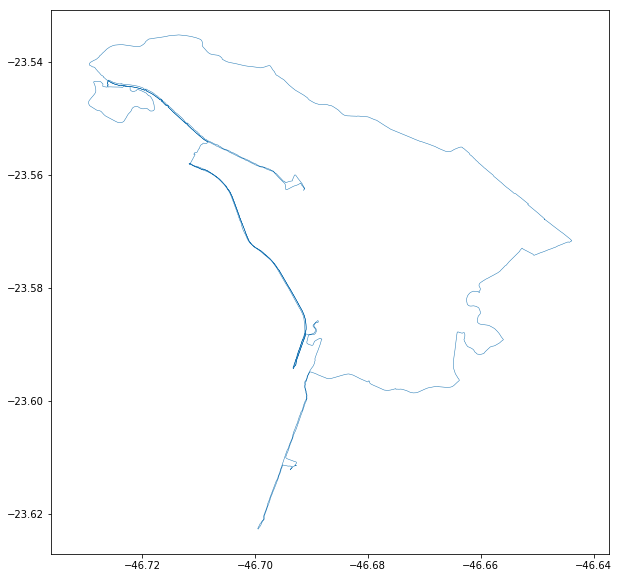

In [23]:
seg = data[data.rider==0]
seg = seg[seg.ride==0]

# this will print the sum of seconds. A greater than 2000
plt.figure(figsize=(10,10))
plt.subplot(111).plot(seg.longitude, seg.latitude, linewidth=0.5)
plt.axis('equal')
plt.show()

# Viewing the Speed

 9508.90 km
  592.65 hrs
    4.46 m/s


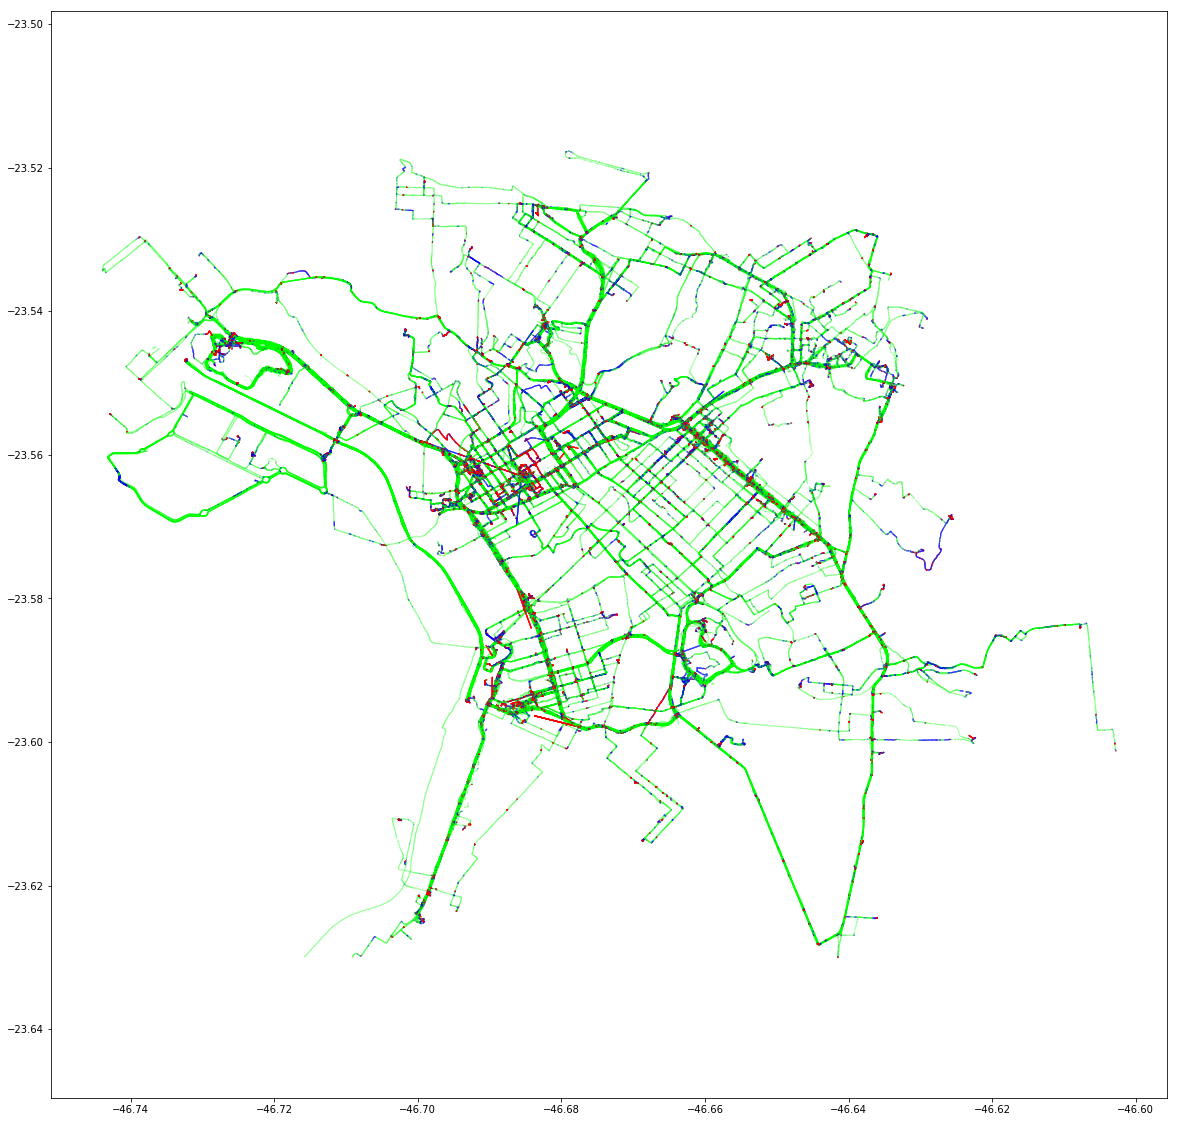

In [226]:
seg = data
seg = seg[seg.latitude > -23.63] #east boundary
seg = seg[seg.latitude < -23.50] #west boundary
seg = seg[seg.longitude > -46.76] #north boundary
seg = seg[seg.longitude < -46.60] #south boundary

# create the mean speed of vector
seg['glat'] = np.around(seg.latitude, 4)
seg['glon'] = np.around(seg.longitude, 4)
seg['gdir'] = round(seg.heading/45)*45
distancemean = pd.DataFrame(seg.groupby(['glat', 'glon', 'gdir'], axis=0)['distance'].mean())
distancemean = np.clip(distancemean, 0, 5) #limit "maximum speed" color slightly above average.
seg = seg.merge(distancemean, left_on=['glat', 'glon', 'gdir'], right_index=True, suffixes=('', 'mean'))
# print(seg.columns)

print("{: 8.2f} {}".format(sum(seg.distance)/1000, "km"))
print("{: 8.2f} {}".format(len(seg)/60/60, "hrs"))
print("{: 8.2f} {}".format(np.mean(seg.distance), "m/s"))

plt.figure(figsize=(20, 20))
C = [(1,0,0),(0,0,1),(0,1,0)]
cm = colors.ListedColormap(C)
# cm = plt.cm.get_cmap('winter')
plt.scatter(seg.longitude, seg.latitude, s=0.01, alpha=1, c=seg.distancemean, cmap=cm)
# plt.scatter(seg.longitude, seg.latitude, linewidth=0.5, alpha=0.5, color='black')

plt.axis('equal')
plt.show()

# plt.savefig('elevations600.png', dpi=300, transparent=False)
# plt.savefig('elevations600.eps', dpi=600, transparent=True)

Index(['elevation', 'latitude', 'longitude', 'point', 'ride', 'rider',
       'timestamp', 'llat', 'llon', 'distance', 'heading', 'deltadistance',
       'deltaelevation'],
      dtype='object')


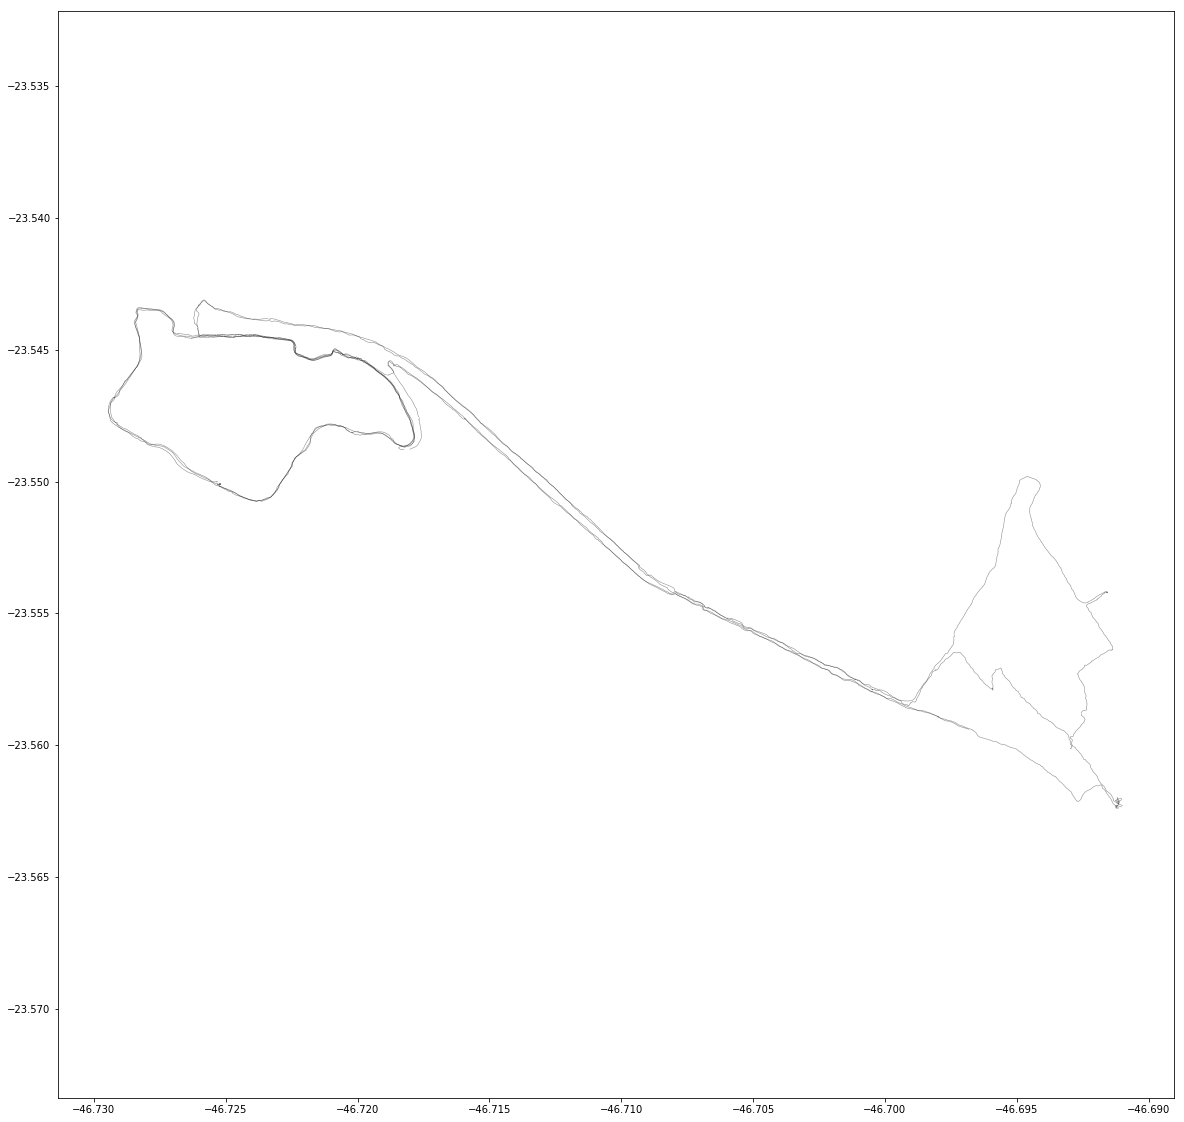

In [321]:
from matplotlib.path import Path
import matplotlib.patches as patches

def printpath(x):
    verts = [
        (x.llon, x.llat),
        (x.longitude, x.latitude),
    ]
    path = Path(verts)
    patch = patches.PathPatch(path, lw=0.5, alpha=0.5, )
    ax.add_patch(patch)


seg = data
seg = seg[seg.latitude > -23.63] #east boundary
seg = seg[seg.latitude < -23.50] #west boundary
seg = seg[seg.longitude > -46.76] #north boundary
seg = seg[seg.longitude < -46.60] #south boundary



# fig, ax = plt.subplots(figsize=(20, 20))
fig = plt.figure
ax = fig.add_subplot(111)


print(seg.columns)
seg[0:10000].apply(printpath, axis=1, raw=False)
    
ax.axis('equal')
ax.autoscale_view()
plt.show()